In [1]:
import pandas as pd
import altair as alt

def plot_yearly_passenger_trends(start_year):
    all_data = []

    # Load each year's file
    for year in range(start_year, 2026):
        try:
            df = pd.read_csv(f"data/clean_data/flights_{year}_clean.csv")

            # Aggregate to monthly totals
            monthly = df.groupby('MONTH')['PASSENGERS'].sum().reset_index()
            monthly['YEAR'] = year
            monthly['date'] = pd.to_datetime(
                monthly['YEAR'].astype(str) + "-" + monthly['MONTH'].astype(str) + "-01"
            )

            all_data.append(monthly)
        except FileNotFoundError:
            print(f"Missing file for {year} — skipping.")
            continue

    # Combine all years
    if not all_data:
        raise ValueError("No data loaded.")
    data = pd.concat(all_data, ignore_index=True)

    # --------------------------
    # Crisis + recovery intervals
    # --------------------------
    highlight_periods = pd.DataFrame({
        'start': [
            '2001-01-01',  # 9/11
            '2008-01-01',  # financial crisis
            '2019-10-01'   # covid
        ],
        'end': [
            '2002-01-31',
            '2009-12-31',
            '2021-01-01'
        ],
        'event': [
            '9/11 Aftermath',
            '2008 Financial Crisis',
            'COVID-19 Impact'
        ]
    })

    highlight_periods['start'] = pd.to_datetime(highlight_periods['start'])
    highlight_periods['end']   = pd.to_datetime(highlight_periods['end'])

    # Shaded rectangles
    rects = alt.Chart(highlight_periods).mark_rect(
        opacity=0.25,
        color='red'
    ).encode(
        x='start:T',
        x2='end:T'
    )

    # Passenger line
    line = alt.Chart(data).mark_line(point=True).encode(
        x=alt.X('date:T', title='Date'),
        y=alt.Y('PASSENGERS:Q', title='Total Monthly Passengers'),
        color=alt.value('#1f77b4'),
        tooltip=[
            alt.Tooltip('date:T', title='Month'),
            alt.Tooltip('PASSENGERS:Q', title='Passengers', format=','),
        ]
    )

    # Event labels at the top of shaded regions
    labels = alt.Chart(highlight_periods).mark_text(
        align='left',
        baseline='bottom',
        dx=3,
        dy=3,
        fontSize=12,
        fontWeight='bold'
    ).encode(
        x='start:T',
        y=alt.value(10),
        text='event'
    )

    chart = (rects + line + labels).properties(
        width=900,
        height=400,
        title="Monthly Passenger Trends Over Time"
    )

    return chart



In [2]:
plot_yearly_passenger_trends(1999)

alt.LayerChart(...)

In [18]:
import pandas as pd
import altair as alt
import glob
import os

alt.data_transformers.disable_max_rows()

# ----------------------------
# LOAD ALL CLEAN CSV FILES
# ----------------------------
files = sorted(glob.glob("data/clean_data/flights_*_clean.csv"))

df_list = []
for f in files:
    filename = os.path.basename(f)
    year = int(filename.split("_")[1])
    
    temp = pd.read_csv(f)
    temp["YEAR"] = year
    df_list.append(temp)

df = pd.concat(df_list, ignore_index=True)

# ----------------------------
# AGGREGATE BY YEAR × SEASON
# ----------------------------
grouped = (
    df.groupby(["YEAR", "SEASON"])
      .agg({
          "PASSENGERS": "sum",
          "SEATS": "sum",
          "DEPARTURES_PERFORMED": "sum",
          "capacity_percent": "mean"
      })
      .reset_index()
)

season_order = ["Winter", "Spring", "Summer", "Fall"]

# Custom season colors (RIGHT VIZ)
season_colors = {
    "Winter": "#1e3a8a",   # dark blue
    "Spring": "#10b981",   # green
    "Summer": "#f59e0b",   # warm orange
    "Fall":   "#b45309"    # brown/orange
}

# ----------------------------
# BRUSH SELECTION
# ----------------------------
brush = alt.selection_interval(encodings=["x", "y"])

# ----------------------------
# SCATTER PLOT (LEFT)
# ----------------------------
scatter = (
    alt.Chart(grouped)
    .mark_circle(size=60, opacity=0.7)  # Smaller points
    .encode(
        x=alt.X("SEATS:Q", title="Total Seasonal Seats"),
        y=alt.Y("PASSENGERS:Q", title="Total Seasonal Passengers"),
        
        # FIX 1: Use monochromatic blue scale + legend
        color=alt.Color(
            "capacity_percent:Q",
            title="Load Factor",
            scale=alt.Scale(
                domain=[grouped.capacity_percent.min(), grouped.capacity_percent.max()],
                scheme="reds"   # single-hue blue palette
            ),
            legend=alt.Legend(title="Load Factor", orient="right")
        ),
        
        size=alt.Size(
            "DEPARTURES_PERFORMED:Q",
            title="Departures Performed",
            scale=alt.Scale(range=[10, 300]),  # Slightly smaller spread
            legend=alt.Legend(orient='left')
        ),

        shape=alt.Shape("SEASON:N", sort=season_order),

        tooltip=[
            "YEAR:O",
            "SEASON:N",
            alt.Tooltip("capacity_percent:Q", title="Load Factor", format=".2f"),
            "PASSENGERS:Q",
            "SEATS:Q",
            "DEPARTURES_PERFORMED:Q"
        ]
    )
    .add_params(brush)
    .properties(
        width=600,
        height=450,
        title="Seasonal Scatter — Select a Region"
    )
)

# ----------------------------
# HISTOGRAM / BAR CHART (RIGHT)
# ----------------------------
hist = (
    alt.Chart(grouped)
    .mark_bar(opacity=0.9)
    .encode(
        x=alt.X(
            "capacity_percent:Q",
            bin=alt.Bin(maxbins=20),
            title="Load Factor (capacity_percent)"
        ),
        y=alt.Y("count()", title="Number of Seasonal Points"),

        # FIX 2: Explicit season → color mapping so bars match legend exactly
        color=alt.Color(
            "SEASON:N",
            sort=season_order,
            title="Season",
            scale=alt.Scale(domain=list(season_colors.keys()),
                            range=list(season_colors.values()))
        ),

        tooltip=[
            alt.Tooltip("SEASON:N", title="Season"),
            alt.Tooltip("count()", title="Count of Points"),
            alt.Tooltip("capacity_percent:Q", title="Load Factor (Range)", format=".2f")
        ]
    )
    .transform_filter(brush)
    .properties(
        width=300,
        height=450,
        title="Load Factor Distribution — Selected Region"
    )
)

# ----------------------------
# FINAL LINKED VIEW
# ----------------------------
final_chart = scatter | hist

final_chart


alt.HConcatChart(...)

In [19]:
final_chart.save("linked_scatter_histogram.json")


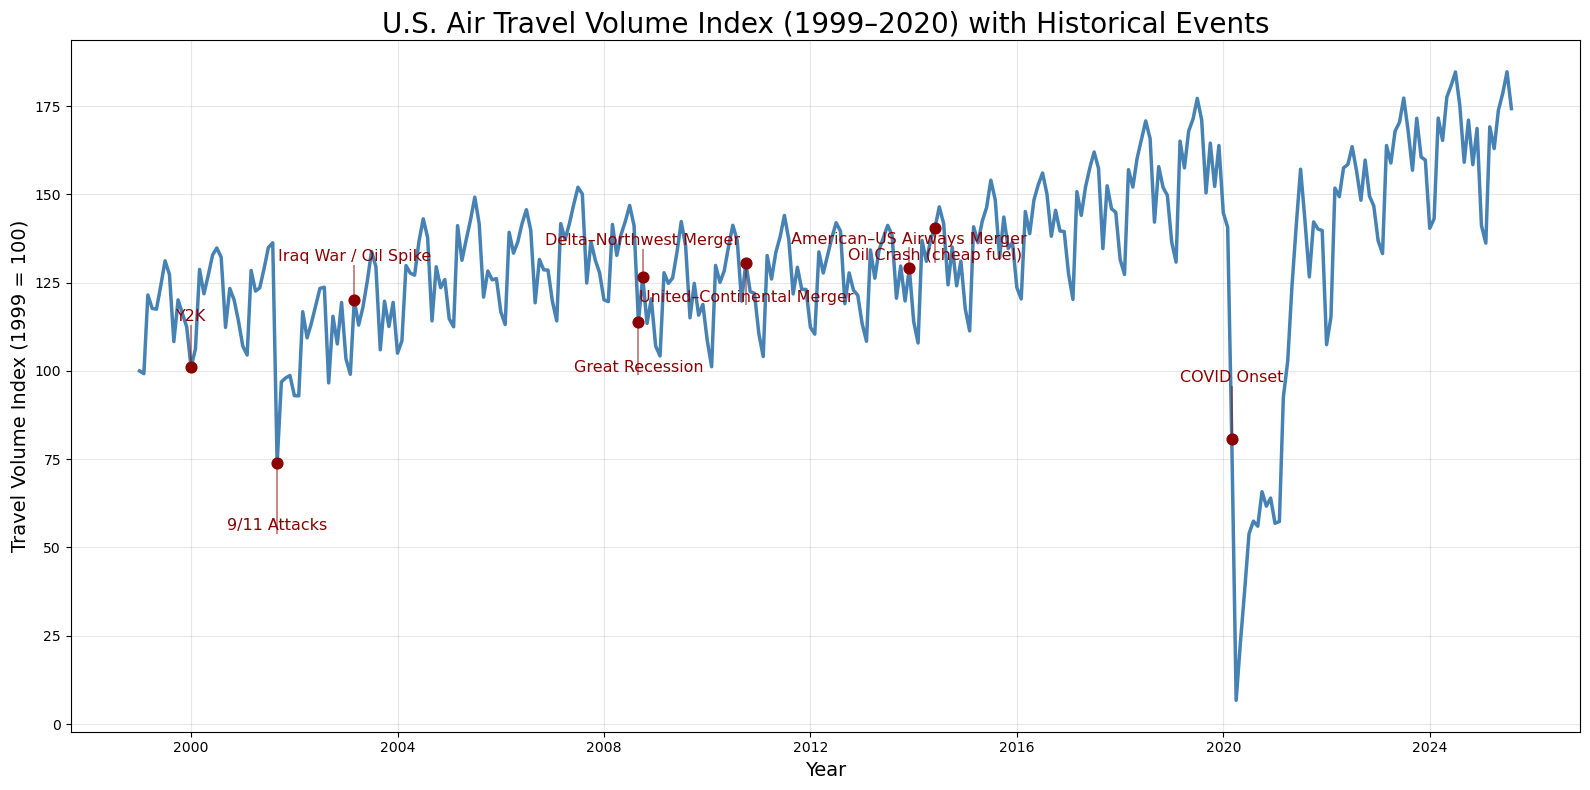

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# -----------------------------
# Load & prepare dataset
# -----------------------------
df = pd.read_json("webpage_deliverable/data/monthly_metrics.json")

# Create unified datetime column
df["date"] = pd.to_datetime(df[["YEAR", "MONTH"]].assign(DAY=1))

# Sum all sectors (Domestic + International + Unknown)
df_total = df.groupby("date")["PASSENGERS"].sum().reset_index()

# Normalize to create "volume index" (1999 start = 100)
base = df_total["PASSENGERS"].iloc[0]
df_total["volume_index"] = (df_total["PASSENGERS"] / base) * 100

# -----------------------------
# Historical events
# -----------------------------
events = {
    "Y2K": "2000-01-01",
    "9/11 Attacks": "2001-09-01",
    "Iraq War / Oil Spike": "2003-03-01",
    "Great Recession": "2008-09-01",
    "Delta–Northwest Merger": "2008-10-01",
    "United–Continental Merger": "2010-10-01",
    "American–US Airways Merger": "2013-12-01",
    "Oil Crash (cheap fuel)": "2014-06-01",
    "COVID Onset": "2020-03-01"
}

# Convert to datetime objects
events = {label: datetime.strptime(date, "%Y-%m-%d") for label, date in events.items()}

# -----------------------------
# Offsets to avoid overlap
# -----------------------------
offsets = {
    "Y2K": 12,
    "9/11 Attacks": -20,
    "Iraq War / Oil Spike": 10,
    "Great Recession": -15,
    "Delta–Northwest Merger": 8,
    "United–Continental Merger": -12,
    "American–US Airways Merger": 6,
    "Oil Crash (cheap fuel)": -10,
    "COVID Onset": 15
}

# -----------------------------
# Create the plot
# -----------------------------
plt.figure(figsize=(16, 8))

# Trend line
plt.plot(df_total["date"], df_total["volume_index"], linewidth=2.5, color="steelblue")
plt.title("U.S. Air Travel Volume Index (1999–2020) with Historical Events", fontsize=20)
plt.ylabel("Travel Volume Index (1999 = 100)", fontsize=14)
plt.xlabel("Year", fontsize=14)

plt.grid(alpha=0.3)

# -----------------------------
# Add event markers + labels
# -----------------------------
for label, date in events.items():
    # Find closest y-value
    y_val = df_total.loc[df_total["date"] == date, "volume_index"]
    if not y_val.empty:
        y = y_val.values[0]

        # Marker
        plt.scatter(date, y, color="darkred", s=60, zorder=5)

        # Guide line up/down to text label
        plt.vlines(date, y, y + offsets[label], color="darkred", linewidth=1.2, alpha=0.55)

        # Label
        plt.text(
            date,
            y + offsets[label] + 1,
            label,
            fontsize=11.5,
            color="darkred",
            ha="center"
        )

# -----------------------------
# Formatting
# -----------------------------
plt.tight_layout()

# Save a PNG (optional)
plt.savefig("annotated_timeline.png", dpi=300, bbox_inches="tight")

plt.show()
